# 1. Import Library & Load Dataset

In [14]:
# Jalankan sel ini untuk menginstal library yang diperlukan
!pip install wordcloud

# Impor semua library yang akan kita gunakan
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from wordcloud import WordCloud

# Download resource NLTK (untuk tokenisasi dan stopwords)
nltk.download('punkt')
nltk.download('stopwords')

print("Setup Selesai. Silakan upload file Anda di bawah.")

# Perintah untuk upload file
# Setelah menjalankan sel ini, tombol 'Choose Files' akan muncul.
# Silakan upload data.csv, abusive.csv, dan new_kamusalay.csv
uploaded = files.upload()

print("\nFile berhasil di-upload:")
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Setup Selesai. Silakan upload file Anda di bawah.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



File berhasil di-upload:


Membuat Pie Chart Distribusi Label...


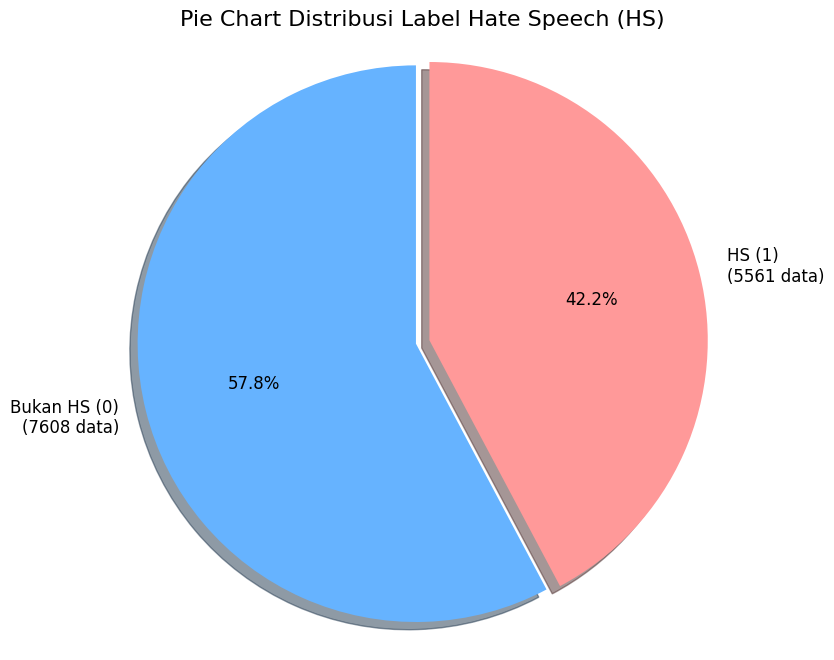

In [21]:
print("Membuat Pie Chart Distribusi Label...")

try:
    # Muat dataset utama
    try:
        df = pd.read_csv('data.csv')
    except UnicodeDecodeError:
        df = pd.read_csv('data.csv', encoding='latin-1')

    # Pastikan nama kolom 'HS' sudah benar
    if 'HS' in df.columns:
        # 1. Hitung distribusi label
        label_counts = df['HS'].value_counts()

        # 2. Siapkan data untuk pie chart
        # Buat label yang lebih deskriptif
        labels = [f'Bukan HS (0)\n({label_counts.get(0, 0)} data)',
                  f'HS (1)\n({label_counts.get(1, 0)} data)']
        sizes = [label_counts.get(0, 0), label_counts.get(1, 0)]
        colors = ['#66b3ff', '#ff9999'] # Warna biru muda dan merah muda
        explode = (0.05, 0)  # "Meledakkan" irisan pertama (Bukan HS)

        # 3. Buat pie chart
        plt.figure(figsize=(8, 8))
        plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=True, startangle=90,
                textprops={'fontsize': 12}) # Memperbesar font

        plt.title('Pie Chart Distribusi Label Hate Speech (HS)', fontsize=16)
        plt.axis('equal')  # Memastikan pie chart terlihat bulat
        plt.show()

    else:
        print("Error: Kolom 'HS' tidak ditemukan di 'data.csv'.")
        print("Silakan periksa kembali file Anda.")

except FileNotFoundError:
    print("Error: File 'data.csv' tidak ditemukan.")
    print("Silakan upload file 'data.csv' terlebih dahulu.")
except Exception as e:
    print(f"Terjadi error: {e}")

--- 5 Data Teratas ---
                                               Tweet  HS
0  - disaat semua cowok berusaha melacak perhatia...   1
1  RT USER: USER siapa yang telat ngasih tau elu?...   0
2  41. Kadang aku berfikir, kenapa aku tetap perc...   0
3  USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...   0
4  USER USER Kaum cebong kapir udah keliatan dong...   1

--- Distribusi Label ---
HS
0    7608
1    5561
Name: count, dtype: int64


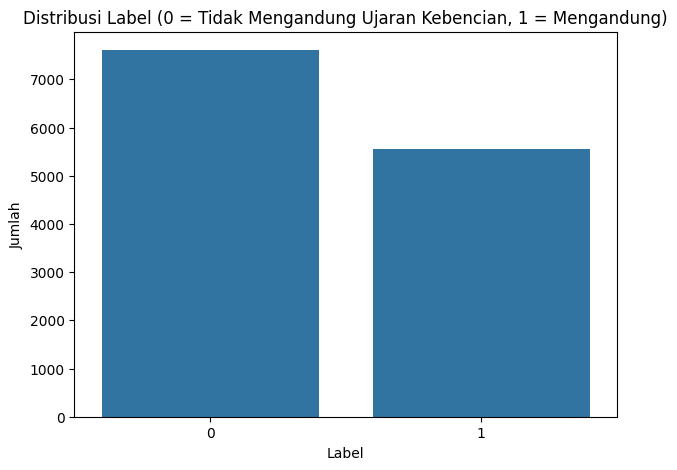

In [15]:
# Muat dataset utama
# Saya tambahkan encoding='latin-1' karena umum untuk error pada data media sosial
try:
    df = pd.read_csv('data.csv')
except UnicodeDecodeError:
    df = pd.read_csv('data.csv', encoding='latin-1')

# Kita hanya butuh kolom 'Tweet' dan 'HS' (Hate Speech)
# Pastikan nama kolom 'HS' sudah benar
df_main = df[['Tweet', 'HS']].copy()

# Cek 5 data teratas
print("--- 5 Data Teratas ---")
print(df_main.head())

# Cek distribusi label
print("\n--- Distribusi Label ---")
print(df_main['HS'].value_counts())

# Visualisasikan distribusi label
plt.figure(figsize=(7, 5))
sns.countplot(x='HS', data=df_main)
plt.title('Distribusi Label (0 = Tidak Mengandung Ujaran Kebencian, 1 = Mengandung)')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

In [16]:
# Muat file pendukung
# new_kamusalay.csv untuk normalisasi kata alay
df_alay = pd.read_csv('new_kamusalay.csv', header=None, names=['alay', 'baku'], encoding='latin-1')
# abusive.csv untuk daftar kata kasar
df_abusive = pd.read_csv('abusive.csv', header=None, names=['abusive'], encoding='latin-1')

# 1. Buat kamus (dictionary) dari file alay untuk pencarian cepat
alay_dict = dict(zip(df_alay['alay'], df_alay['baku']))

# 2. Siapkan daftar stopwords bahasa Indonesia
list_stopwords = stopwords.words('indonesian')

# 3. PENTING: Hapus kata-kata kasar dari daftar stopwords
# Kita ingin model TAHU kata-kata ini, bukan membuangnya.
abusive_set = set(df_abusive['abusive'])
list_stopwords = [word for word in list_stopwords if word not in abusive_set]

# Fungsi untuk membersihkan teks
def preprocess_text(text):
    text = str(text).lower() # Case folding [cite: 25]

    # Normalisasi kata alay menggunakan kamus
    words = text.split()
    normalized_words = [alay_dict.get(word, word) for word in words]
    text = ' '.join(normalized_words)

    # Hapus URL, mention, hashtag, dan karakter non-alfanumerik
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text) # Hapus angka [cite: 26]
    text = re.sub(r'[^\w\s]', '', text) # Hapus tanda baca [cite: 26]

    # Tokenisasi [cite: 27]
    tokens = word_tokenize(text)

    # Stopword removal [cite: 28]
    cleaned_tokens = [word for word in tokens if word not in list_stopwords]

    # Stemming (Opsional, bisa di-skip jika terlalu lama) [cite: 29]
    # from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    # factory = StemmerFactory()
    # stemmer = factory.create_stemmer()
    # stemmed_tokens = [stemmer.stem(token) for token in cleaned_tokens]
    # return ' '.join(stemmed_tokens)

    return ' '.join(cleaned_tokens)

# Download resource NLTK (untuk tokenisasi dan stopwords)
nltk.download('punkt_tab') # Added punkt_tab download
nltk.download('punkt')
nltk.download('stopwords')


# Terapkan fungsi preprocessing ke kolom 'Tweet'
print("Memulai preprocessing... (Ini mungkin butuh beberapa menit)")
df_main['cleaned_tweet'] = df_main['Tweet'].apply(preprocess_text)
print("Preprocessing selesai.")

# Tampilkan hasil perbandingan
print("\n--- Hasil Preprocessing ---")
print(df_main[['Tweet', 'cleaned_tweet']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Memulai preprocessing... (Ini mungkin butuh beberapa menit)
Preprocessing selesai.

--- Hasil Preprocessing ---
                                               Tweet  \
0  - disaat semua cowok berusaha melacak perhatia...   
1  RT USER: USER siapa yang telat ngasih tau elu?...   
2  41. Kadang aku berfikir, kenapa aku tetap perc...   
3  USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...   
4  USER USER Kaum cebong kapir udah keliatan dong...   

                                       cleaned_tweet  
0  cowok berusaha melacak perhatian gue lantas re...  
1  rt user pengguna telat tau eluedan sarap gue b...  
2  kadang berfikir percaya tuhan jatuh berkalikal...  
3         pengguna pengguna akunnku tau matamu sipit  
4  pengguna pengguna kaum cebong kafir dongoknya ...  


In [17]:
# Tentukan X (fitur) dan y (label)
X = df_main['cleaned_tweet']
y = df_main['HS']

# Bagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Jumlah data latih: {len(X_train)}")
print(f"Jumlah data uji: {len(X_test)}")

# Buat Pipeline
# Langkah 1: TF-IDF Vectorizer
# Langkah 2: Model (Logistic Regression)
pipeline_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)), # max_features membatasi jumlah fitur
    ('model', LogisticRegression(max_iter=1000))
])

# Latih model menggunakan data latih
print("\nMelatih model...")
pipeline_model.fit(X_train, y_train)
print("Model selesai dilatih.")

Jumlah data latih: 10535
Jumlah data uji: 2634

Melatih model...
Model selesai dilatih.


--- HASIL EVALUASI MODEL ---
Accuracy: 81.70%

Classification Report:
              precision    recall  f1-score   support

Bukan HS (0)       0.81      0.89      0.85      1522
      HS (1)       0.82      0.72      0.77      1112

    accuracy                           0.82      2634
   macro avg       0.82      0.80      0.81      2634
weighted avg       0.82      0.82      0.81      2634


Confusion Matrix:


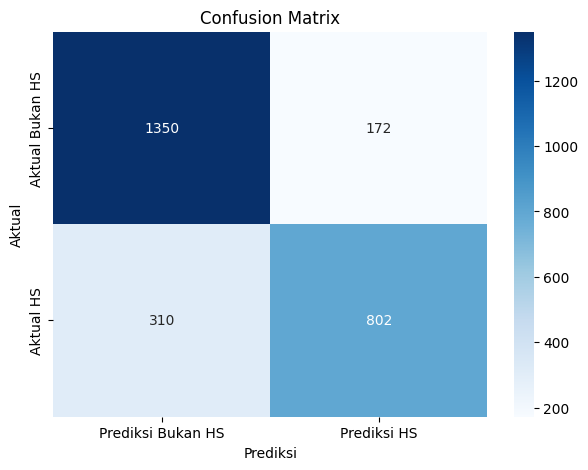


--- Interpretasi Hasil ---
-> Precision (HS): 82.34%
   (Artinya: Dari semua teks yang diprediksi model sebagai ujaran kebencian, 82.34%-nya memang benar.)
-> Recall (HS): 72.12%
   (Artinya: Dari semua ujaran kebencian yang sebenarnya ada di data uji, model berhasil mengenali 72.12%-nya.)


In [18]:
# Lakukan prediksi pada data uji
y_pred = pipeline_model.predict(X_test)

# Tampilkan hasil evaluasi
print("--- HASIL EVALUASI MODEL ---")

# 1. Accuracy [cite: 41]
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# 2. Classification Report (Precision, Recall, F1-Score) [cite: 42-44]
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Bukan HS (0)', 'HS (1)']))

# 3. Confusion Matrix [cite: 40]
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prediksi Bukan HS', 'Prediksi HS'],
            yticklabels=['Aktual Bukan HS', 'Aktual HS'])
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.title('Confusion Matrix')
plt.show()

# 4. Interpretasi [cite: 45]
print("\n--- Interpretasi Hasil ---")
precision_hs = precision_score(y_test, y_pred, pos_label=1)
recall_hs = recall_score(y_test, y_pred, pos_label=1)
print(f"-> Precision (HS): {precision_hs*100:.2f}%")
print(f"   (Artinya: Dari semua teks yang diprediksi model sebagai ujaran kebencian, {precision_hs*100:.2f}%-nya memang benar.)")
print(f"-> Recall (HS): {recall_hs*100:.2f}%")
print(f"   (Artinya: Dari semua ujaran kebencian yang sebenarnya ada di data uji, model berhasil mengenali {recall_hs*100:.2f}%-nya.)")

Memulai proses Word Cloud dengan Top 5 Kata...
Melakukan preprocessing...
Preprocessing selesai.

--- Analisis Kelas Ujaran Kebencian (HS = 1) ---
Top 5 Kata Teratas (HS = 1):
- pengguna: 7613 kali
- indonesia: 689 kali
- jokowi: 672 kali
- rt: 573 kali
- uniform: 506 kali


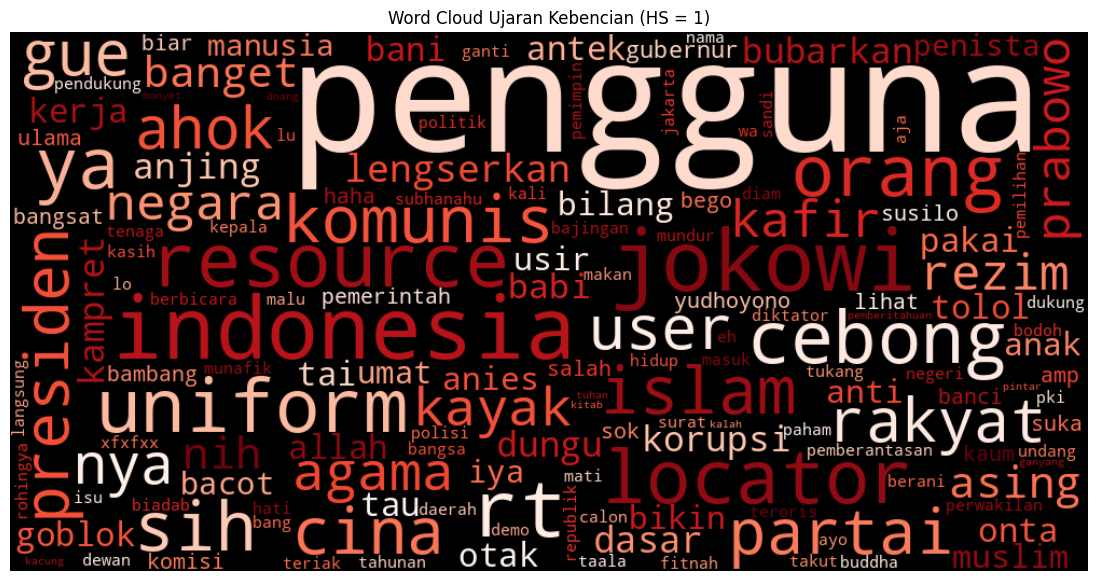


--- Analisis Kelas Netral (HS = 0) ---
Top 5 Kata Teratas (HS = 0):
- pengguna: 7782 kali
- orang: 755 kali
- gue: 731 kali
- presiden: 657 kali
- ya: 590 kali


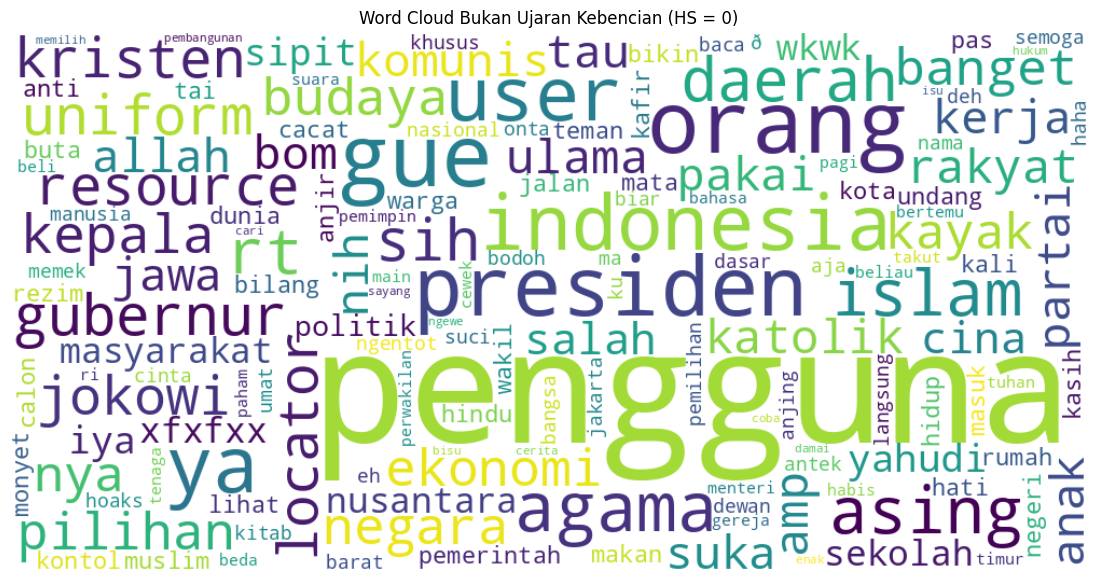

In [23]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Download resource NLTK (jika belum ada)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("Memulai proses Word Cloud dengan Top 5 Kata...")

try:
    # --- Blok 1: Muat Data dan Preprocessing ---
    # Ini diperlukan agar sel ini bisa berjalan mandiri

    # Muat dataset utama
    try:
        df = pd.read_csv('data.csv')
    except UnicodeDecodeError:
        df = pd.read_csv('data.csv', encoding='latin-1')

    # Muat file pendukung
    df_alay = pd.read_csv('new_kamusalay.csv', header=None, names=['alay', 'baku'], encoding='latin-1')
    df_abusive = pd.read_csv('abusive.csv', header=None, names=['abusive'], encoding='latin-1')

    df_main = df[['Tweet', 'HS']].copy()

    alay_dict = dict(zip(df_alay['alay'], df_alay['baku']))
    abusive_set = set(df_abusive['abusive'])
    list_stopwords = stopwords.words('indonesian')
    list_stopwords = [word for word in list_stopwords if word not in abusive_set]

    def preprocess_text(text):
        text = str(text).lower()
        words = text.split()
        normalized_words = [alay_dict.get(word, word) for word in words]
        text = ' '.join(normalized_words)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        tokens = word_tokenize(text)
        cleaned_tokens = [word for word in tokens if word not in list_stopwords]
        return ' '.join(cleaned_tokens)

    print("Melakukan preprocessing...")
    df_main['cleaned_tweet'] = df_main['Tweet'].apply(preprocess_text)
    print("Preprocessing selesai.")

    # --- Blok 2: Word Cloud Ujaran Kebencian (HS = 1) + Top 5 ---
    print("\n--- Analisis Kelas Ujaran Kebencian (HS = 1) ---")
    hs_texts = df_main[df_main['HS'] == 1]['cleaned_tweet'].dropna() # .dropna() untuk cegah error

    if not hs_texts.empty:
        # **BARU: Hitung Top 5 Kata**
        try:
            # Vectorizer akan menghitung semua kata
            vec_hs = CountVectorizer().fit(hs_texts)
            bag_of_words_hs = vec_hs.transform(hs_texts)
            sum_words_hs = bag_of_words_hs.sum(axis=0)
            words_freq_hs = [(word, sum_words_hs[0, idx]) for word, idx in vec_hs.vocabulary_.items()]
            words_freq_hs = sorted(words_freq_hs, key = lambda x: x[1], reverse=True)

            print("Top 5 Kata Teratas (HS = 1):")
            for word, count in words_freq_hs[:5]:
                print(f"- {word}: {count} kali")
        except Exception as e:
            print(f"Error saat menghitung Top 5 (HS=1): {e}")

        # Buat Word Cloud (seperti sebelumnya)
        all_hs_text = ' '.join(hs_texts)
        if all_hs_text.strip():
            wordcloud_hs = WordCloud(width=1000, height=500, background_color='black',
                                     max_words=150, collocations=False, colormap='Reds').generate(all_hs_text)
            plt.figure(figsize=(15, 7))
            plt.imshow(wordcloud_hs, interpolation='bilinear')
            plt.title('Word Cloud Ujaran Kebencian (HS = 1)')
            plt.axis('off')
            plt.show()
        else:
            print("Tidak ada teks untuk Word Cloud (HS=1) setelah diproses.")
    else:
        print("Tidak ada data untuk kelas HS = 1.")

    # --- Blok 3: Word Cloud Netral (HS = 0) + Top 5 ---
    print("\n--- Analisis Kelas Netral (HS = 0) ---")
    neutral_texts = df_main[df_main['HS'] == 0]['cleaned_tweet'].dropna()

    if not neutral_texts.empty:
        # **BARU: Hitung Top 5 Kata**
        try:
            vec_neu = CountVectorizer().fit(neutral_texts)
            bag_of_words_neu = vec_neu.transform(neutral_texts)
            sum_words_neu = bag_of_words_neu.sum(axis=0)
            words_freq_neu = [(word, sum_words_neu[0, idx]) for word, idx in vec_neu.vocabulary_.items()]
            words_freq_neu = sorted(words_freq_neu, key = lambda x: x[1], reverse=True)

            print("Top 5 Kata Teratas (HS = 0):")
            for word, count in words_freq_neu[:5]:
                print(f"- {word}: {count} kali")
        except Exception as e:
            print(f"Error saat menghitung Top 5 (HS=0): {e}")

        # Buat Word Cloud (seperti sebelumnya)
        all_neutral_text = ' '.join(neutral_texts)
        if all_neutral_text.strip():
            wordcloud_neutral = WordCloud(width=1000, height=500, background_color='white',
                                          max_words=150, collocations=False).generate(all_neutral_text)
            plt.figure(figsize=(15, 7))
            plt.imshow(wordcloud_neutral, interpolation='bilinear')
            plt.title('Word Cloud Bukan Ujaran Kebencian (HS = 0)')
            plt.axis('off')
            plt.show()
        else:
            print("Tidak ada teks untuk Word Cloud (HS=0) setelah diproses.")
    else:
        print("Tidak ada data untuk kelas HS = 0.")

except FileNotFoundError:
    print("Error: File tidak ditemukan.")
    print("Pastikan file 'data.csv', 'new_kamusalay.csv', dan 'abusive.csv' sudah di-upload.")
except Exception as e:
    print(f"Terjadi error: {e}")

--- Word Cloud Ujaran Kebencian (HS = 1) ---


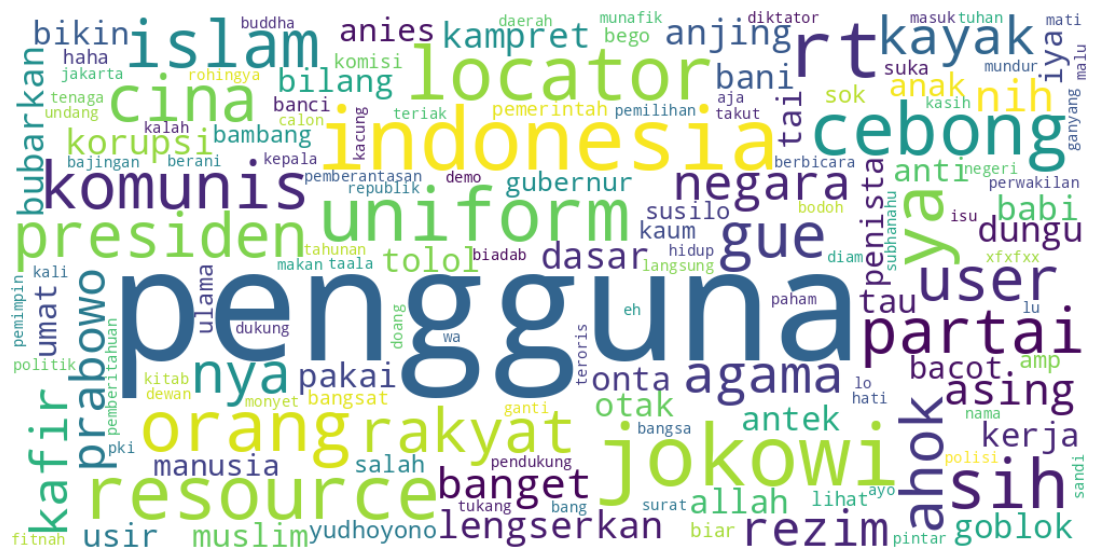

In [19]:
print("--- Word Cloud Ujaran Kebencian (HS = 1) ---")

# Ambil semua teks yang bersih dari label HS = 1
hs_texts = df_main[df_main['HS'] == 1]['cleaned_tweet']

# Gabungkan menjadi satu string teks besar
all_hs_text = ' '.join(hs_texts)

# Buat dan tampilkan word cloud
if all_hs_text: # Cek apakah string tidak kosong
    wordcloud = WordCloud(width=1000, height=500, background_color='white',
                          max_words=150, collocations=False).generate(all_hs_text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
else:
    print("Tidak ada teks ujaran kebencian yang ditemukan untuk dibuatkan word cloud.")

--- Word Cloud Bukan Ujaran Kebencian (HS = 0) ---


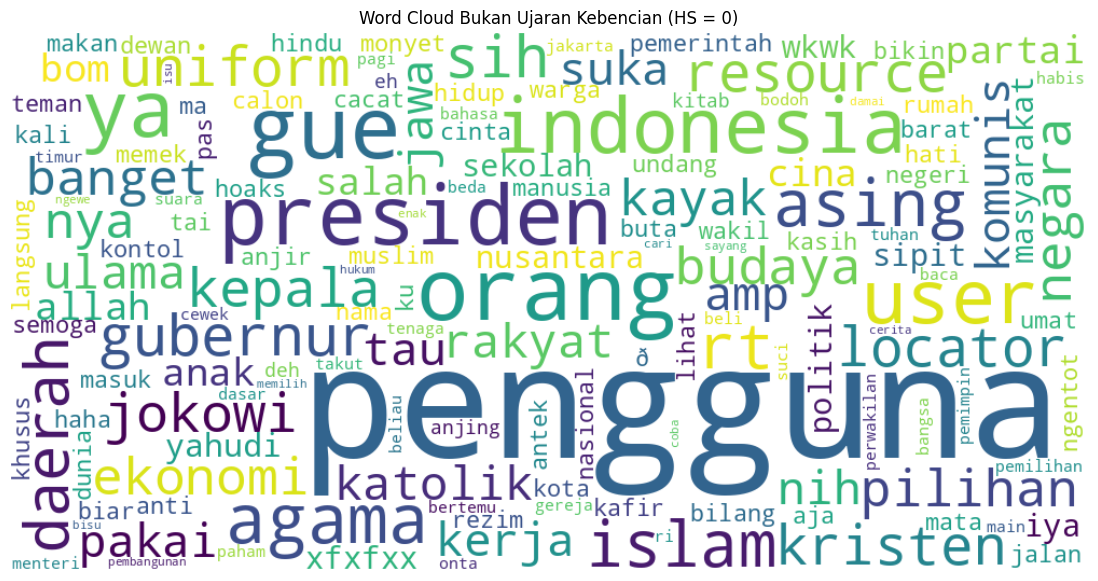

In [20]:
# --- Tambahan: Word Cloud untuk Kelas Neutral (HS = 0) ---
# Pastikan Anda sudah menjalankan sel preprocessing sebelumnya
# sehingga variabel 'df_main' sudah ada.

print("--- Word Cloud Bukan Ujaran Kebencian (HS = 0) ---")

# Ambil semua teks yang bersih dari label HS = 0
neutral_texts = df_main[df_main['HS'] == 0]['cleaned_tweet']

# Gabungkan menjadi satu string teks besar
all_neutral_text = ' '.join(neutral_texts)

# Buat dan tampilkan word cloud
if all_neutral_text: # Cek apakah string tidak kosong
    # Anda bisa mengatur background_color ke 'white' atau warna lain
    wordcloud_neutral = WordCloud(width=1000, height=500, background_color='white',
                                  max_words=150, collocations=False).generate(all_neutral_text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud_neutral, interpolation='bilinear')
    plt.title('Word Cloud Bukan Ujaran Kebencian (HS = 0)')
    plt.axis('off')
    plt.show()
else:
    print("Tidak ada teks 'Bukan HS' (HS=0) yang ditemukan untuk dibuatkan word cloud.")